In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle as pkl

In [3]:
# Load your dataset (adjust the path if needed)
df = pd.read_csv('all_data.csv')
# Set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].sort_values(ascending=False) 
df.set_index('Date', inplace=True)

In [4]:
df.head()

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,is_holiday,gold_price_to_predict,gold_price_yesterday,gold_price_2days,gold_price_3days
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,80.24,80.10,0.00,235.288,203.8,1,118.000000,NaN,NaN,NaN
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,80.71,80.08,0.75,235.288,203.8,0,119.290001,NaN,NaN,NaN
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,80.89,80.49,0.20,235.288,203.8,0,119.500000,118.000000,NaN,NaN
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,80.91,80.54,-0.17,235.288,203.8,0,118.820000,119.290001,118.000000,NaN
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,80.95,80.60,0.22,235.288,203.8,0,118.120003,119.500000,119.290001,118.0


In [5]:
gold_prices = df['gold_Close'].copy().dropna()  # Drop missing values

Checking the stationarity of the difference - we need this for choosing the d parameter of the ARIMA model

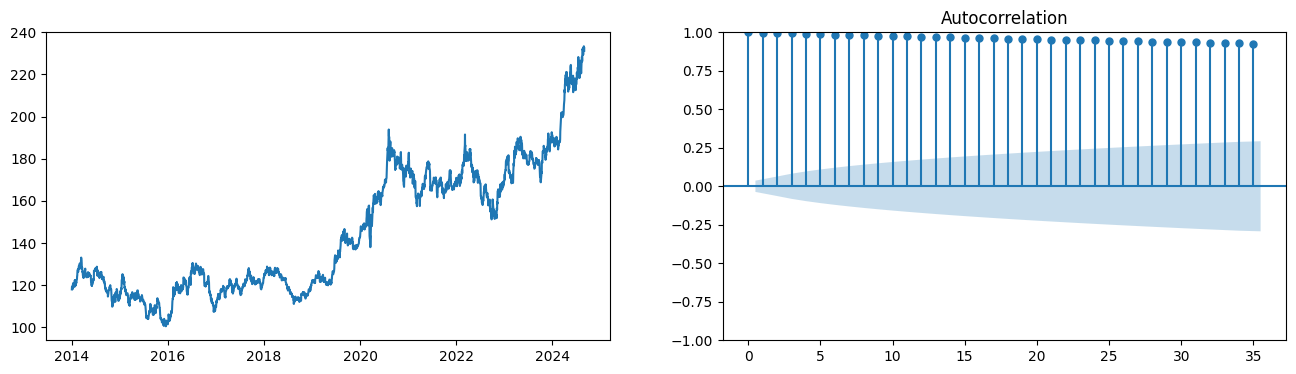

In [6]:
# Regular Prices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(gold_prices)
plot_acf(gold_prices, ax=ax2);

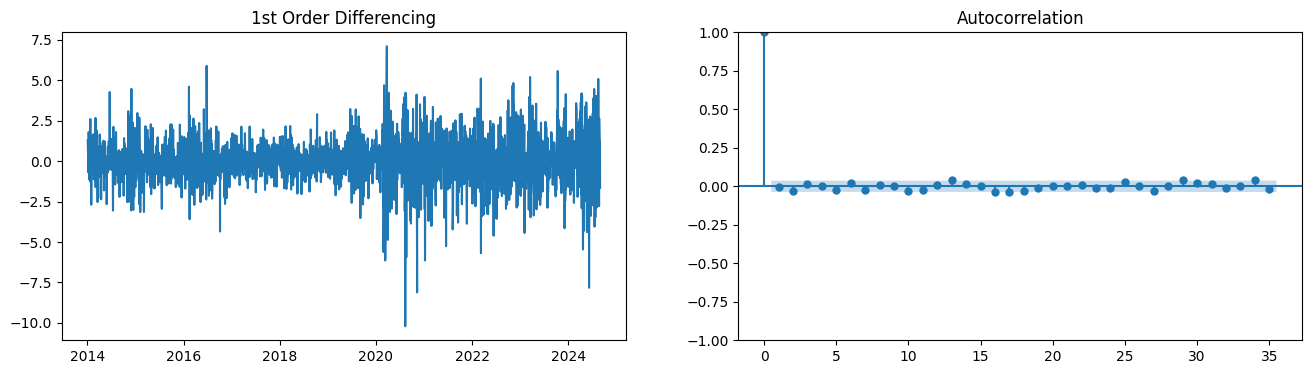

In [7]:
# Difference of the prices (1 day)
from statsmodels.tsa.stattools import adfuller
diff = gold_prices.diff().dropna()
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('1st Order Differencing')
plot_acf(diff, ax=ax2);

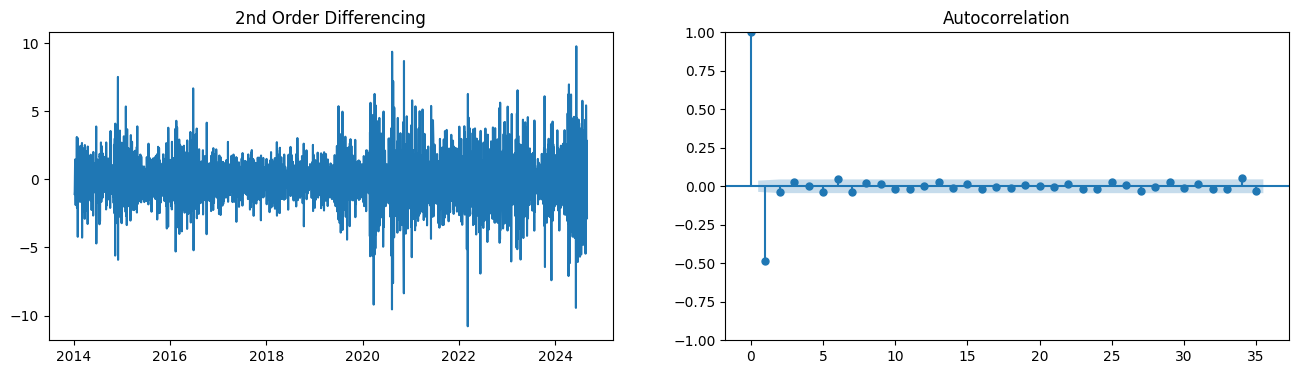

In [8]:
# Difference of the prices (2 days)
diff2 = gold_prices.diff().diff().dropna()
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff2)
ax1.set_title('2nd Order Differencing')
plot_acf(diff2, ax=ax2);

In [15]:
import pmdarima
from pmdarima.arima.utils import ndiffs
ndiffs(gold_prices, test='adf')

ModuleNotFoundError: No module named 'pmdarima'

In [10]:
!pip install pmdarima

In [100]:
column_to_predict = 'gold_Close'
data_to_predict = df[column_to_predict].copy().dropna()
data_to_predict=data_to_predict.to_frame()
#data_to_predict.index = pd.DatetimeIndex(data_to_predict.index).to_period('D')

In [73]:
import warnings
warnings.filterwarnings("ignore")

In [74]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
# Use only the gold_Price column for the ARIMA model

# Split the data into training and testing sets
train_size = int(len(data_to_predict) * 0.8)  # 80% training, 20% testing
train_data, test_data = data_to_predict[:train_size], data_to_predict[train_size:]

# Define and fit the ARIMA model (p, d, q)
# p=4 - looking 4 days back
# d=1 - using the differences
# q=2 - using 2 last errors (?)

model = ARIMA(train_data, order=(4, 1, 2)) 
model_fit = model.fit()
# Print the model summary
print(type(model_fit))
print(model_fit.summary())

# Forecasting one day ahead using the true data each time
history = list(train_data)  # Create a list from the training data
predictions = []
len_test = len(test_data)
for t in range(len_test):
    #print(t)
    yhat = model_fit.forecast(steps=5)
    #print(list(yhat))
    predictions.extend(list(yhat))
    #history.append(test_data.iloc[t])
    model_fit = model_fit.extend(test_data.iloc[t:t+5])
    #model_fit = model_fit.append([yhat])

# Convert predictions to a list of numbers
predictions = [float(pred) for pred in predictions]
print(predictions)
# Convert predictions to a DataFrame for easier plotting
pred_index = data_to_predict.index[train_size:]  # Create an index for predictions
arima_predictions_df = pd.DataFrame(predictions, index=pred_index, columns=['Predictions'])

# Combine predictions and actual test data
test_data = test_data.to_frame()
print(test_data)
arima_predictions_df = test_data.join(arima_predictions_df)
print(arima_predictions_df)
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(arima_predictions_df.index, arima_predictions_df[column_to_predict], color='blue', label=f'Actual {column_to_predict}')
plt.plot(arima_predictions_df.index, arima_predictions_df['Predictions'], color='red', linestyle='--', label=f'Predicted {column_to_predict}')
plt.title(column_to_predict + ' Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions']))
mae = mean_absolute_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions'])

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
                               SARIMAX Results                                
Dep. Variable:            sp500_Price   No. Observations:                 2293
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -11158.646
Date:                Tue, 29 Oct 2024   AIC                          22331.293
Time:                        15:19:28   BIC                          22371.453
Sample:                             0   HQIC                         22345.937
                               - 2293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6823      0.047    -36.087      0.000      -1.774      -1.591
ar.L2         -0.7743      0.050    -15.382      0.000      -0.873      -

ValueError: Given `endog` does not have an index that extends the index of the model.

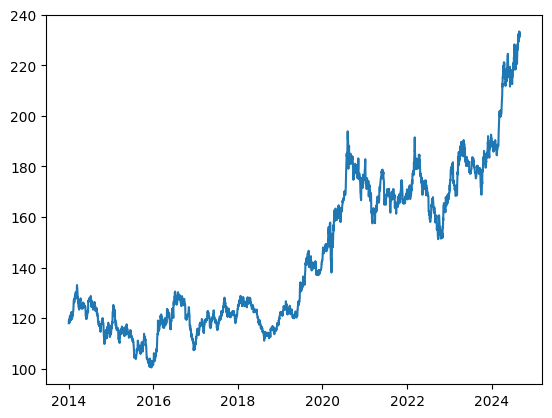

In [28]:
plt.plot(data_to_predict)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                               SARIMAX Results                                
Dep. Variable:             gold_Close   No. Observations:                 2293
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3706.860
Date:                Tue, 29 Oct 2024   AIC                           7425.719
Time:                        16:28:08   BIC                           7460.142
Sample:                             0   HQIC                          7438.272
                               - 2293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1471      0.160     -0.919      0.358      -0.461       0.167
ar.L2          0.7767      0.142      5.477      0.000 

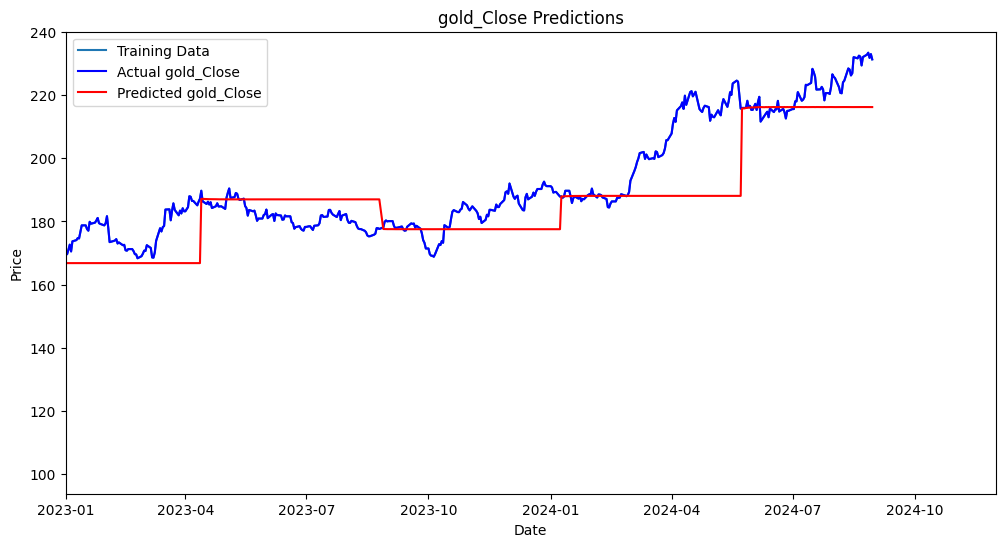

Root Mean Square Error: 10.532215364748568
Mean Absolute Error: 7.4675510155966265


In [108]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
#import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Use only the gold_Price column for the ARIMA model

# Split the data into training and testing sets
train_size = int(len(data_to_predict) * 0.8)  # 80% training, 20% testing
train_data, test_data = data_to_predict[:train_size], data_to_predict[train_size:]
print(type(test_data))
print(type(train_data))
# Define and fit the ARIMA model (p, d, q)
# p=4 - looking 4 days back
# d=1 - using the differences (?)
# q=2 - using 2 last errors (?)
model = ARIMA(train_data, order=(3, 1, 2)) 
model_fit = model.fit()
# Print the model summary
print(model_fit.summary())

# Forecasting one day ahead using the true data each time
history = list(train_data)  # Create a list from the training data
predictions = []
days_forward = 100
for t in range(0, len(test_data), days_forward):
    print(t)
    yhat = model_fit.forecast(steps=min(days_forward, len(test_data)-t))
    predictions.extend(yhat)
    train_data = pd.concat([train_data, test_data.iloc[t:t+days_forward]])
    #model_fit = ARIMA(train_data, order=(4, 1, 2)).fit()
    for i in range(0, min(days_forward, len(test_data)-t)):
        print(list(test_data.iloc[t+i]))
        model_fit = model_fit.append(list(test_data.iloc[t+i]))
    #model_fit = model_fit.append(test_data.iloc[t:t+days_forward])
   

# Convert predictions to a list of numbers
print(predictions)
predictions = [float(pred) for pred in predictions]

# Convert predictions to a DataFrame for easier plotting
pred_index = gold_prices.index[train_size:]  # Create an index for predictions
arima_predictions_df = pd.DataFrame(predictions, index=pred_index, columns=['Predictions'])

# Combine predictions and actual test data
arima_predictions_df = test_data.join(arima_predictions_df)
print(arima_predictions_df)
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(arima_predictions_df.index, arima_predictions_df[column_to_predict], color='blue', label=f'Actual {column_to_predict}')
plt.plot(arima_predictions_df.index, arima_predictions_df['Predictions'], color='red', linestyle='-', label=f'Predicted {column_to_predict}')
plt.title(column_to_predict + ' Predictions')
plt.xlabel('Date')
plt.xlim([pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-01')])

plt.ylabel('Price')
plt.legend()
plt.show()


# Evaluate the model
rmse = np.sqrt(mean_squared_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions']))
mae = mean_absolute_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions'])

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

In [50]:
with open('modelResults/arima_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(arima_predictions_df, file)

[3958.6249015269627, 4004.1111640819886, 3953.4317442253546, 3979.0044524914815, 3909.264164223209, 4029.5238124838547, 4058.8084113178656, 4141.966013108002, 4105.666982461267, 4106.985854983414, 4134.6713375313075, 4169.054527163354, 4134.48261840817, 4145.083565413421, 4123.562454071644, 4199.4683650705265, 4217.632346204917, 4267.500984843322, 4302.587141568914, 4305.219260318153, 4271.582687981138, 4289.103845712957, 4224.529037984621, 4151.344196921765, 4114.9419007318775, 4151.653452043993, 4187.394989490383, 4075.94713424713, 4021.607918726892, 3989.252636262256, 3963.168120380191, 3952.099755745946, 3944.487214265047, 3905.6792574623714, 3938.6965220212464, 3899.928812043494, 3978.576218562611, 4007.3574964163768, 4062.1726049178696, 4110.887394371483, 3947.662237722814, 3932.723562592997, 3909.9793132276122, 3876.17595063044, 3887.814487361543, 3874.271303860251, 3777.457586834983, 3769.9320947986535, 3687.2606494517336, 3661.4374790832503, 3641.2391242148647, 3718.0524930805

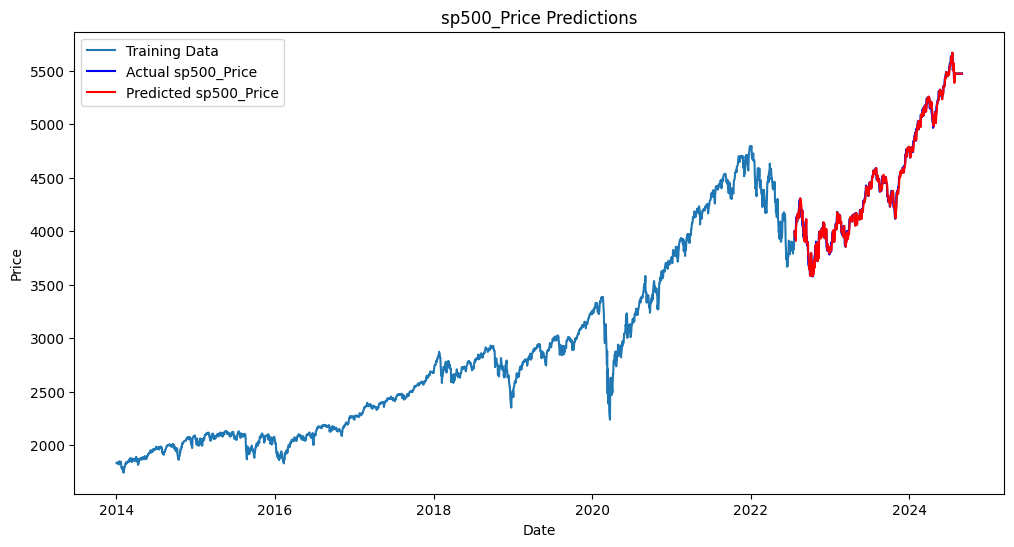

Root Mean Square Error: 39.59601238372672
Mean Absolute Error: 29.020671088242697


In [71]:
print(predictions)
predictions = [float(pred) for pred in predictions]

# Convert predictions to a DataFrame for easier plotting
pred_index = gold_prices.index[train_size:]  # Create an index for predictions
arima_predictions_df = pd.DataFrame(predictions, index=pred_index, columns=['Predictions'])

# Combine predictions and actual test data
arima_predictions_df = test_data.join(arima_predictions_df)
print(arima_predictions_df)
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(arima_predictions_df.index, arima_predictions_df[column_to_predict], color='blue', label=f'Actual {column_to_predict}')
plt.plot(arima_predictions_df.index, arima_predictions_df['Predictions'], color='red', linestyle='-', label=f'Predicted {column_to_predict}')
plt.title(column_to_predict + ' Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Evaluate the model
rmse = np.sqrt(mean_squared_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions']))
mae = mean_absolute_error(arima_predictions_df[column_to_predict], arima_predictions_df['Predictions'])

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")